In [12]:
# Zachary Katz
# zachary_katz@mines.edu
# 10 August 2024

# TODO Plot multple station on the final plot!!!

"""
Load full GNSS data for selected stations.
Find instantaneous velocity and smooth.
Plot figure 6
"""

# Imports
import os
import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from astropy.timeseries import LombScargle

import pandas as pd
import numpy as np
import scipy


import pickle


import pyTMD.io
import pyTMD.time
import timescale


# Class description required to load pickle files
class GPS_data:
    def __init__(self, starts, ends, gaps, data, increment, name):
        self.increment = increment
        self.starts = starts
        self.ends = ends
        self.gaps = gaps
        self.data = data
        self.name = name

In [2]:
data = []

folders = [
    "Pickle2007_2009",
    "Pickle2010_2011",
    "Pickle2012_2013",
    "Pickle2014_2015",
    "Pickle2016_2019",
]
toRun = [
    "la01",
    "la02",
    "la03",
    "la04",
    "la05",
    "la06",
    "la07",
    "la09",
    "la10",
    "la11",
    "la12",
    "la13",
    "la14",
    "la15",
    "ws04",
    "ws05",
    "gz01",
    "gz02",
    "gz03",
    "gz04",
    "gz05",
    "gz06",
    "gz07",
    "gz08",
    "gz09",
    "gz10",
    "gz11",
    "gz12",
    "gz13",
    "gz14",
    "gz15",
    "gz16",
    "gz17",
    "gz18",
    "mg01",
    "mg02",
    "mg03",
    "mg05",
    "mg06",
    "mg07",
]
toRun = ["la07", "la08", "la09", "la10", "gz01", "gz14"]
for sta in toRun:
    sta_data = []
    for folder in folders:
        for file in os.listdir(
            f"/mnt/c/users/ZacharyKatz/Desktop/Research/Catalog/{folder}"
        ):
            if file.endswith(f"{sta}.pkl"):
                with open(
                    f"/mnt/c/users/ZacharyKatz/Desktop/Research/Catalog/{folder}"
                    + "/"
                    + file,
                    "rb",
                ) as pickle_file:  # Load Pickle File
                    ind_data = pickle.load(pickle_file)
                    sta_data.append(ind_data)

    starts = []
    ends = []
    gaps = []

    for i, obj in enumerate(sta_data):
        for st in obj.starts:
            starts.append(st)
        for en in obj.ends:
            ends.append(en)
        for gap in obj.gaps:
            gaps.append(gap)
        if i == 0:
            datafr = obj.data
        else:
            datafr = pd.concat([datafr, obj.data], ignore_index=True)

    combined = GPS_data(starts, ends, gaps, datafr, obj.increment, obj.name)
    data.append(combined)

In [3]:
# Find instantaneous velocity and smooth
def derivative(time, x_col, freq):
    """
    Compute the first and second derivative of a smoothed time series
    Parameters
    time - event with times
    x_col - column of x values of which to take the derivative of

    Returns
    grad - First derivative [list]
    grad2 - Second derivative [list]
    """
    y_data = x_col - np.mean(x_col)
    # print(x_data,y_data)
    try:
        b, a = scipy.signal.butter(4, freq, "low")
        filtered = scipy.signal.filtfilt(b, a, y_data, padlen=50)
        grad = np.gradient(filtered, 15)

        b, a = scipy.signal.butter(4, 0.05)
        grad_filtered = scipy.signal.filtfilt(b, a, grad, padlen=50)
        grad2 = np.gradient(np.gradient(grad_filtered), 15)
    except ValueError:
        grad = np.full(len(y_data), np.nan)
        grad2 = np.full(len(y_data), np.nan)
    return grad, grad2

In [4]:
# Compute average first and second derivatives of all traces.
# Split into sections to avoid gaps.

grad1s = []
grad1_times = []
st_indices = []
ed_indices = []
stas = []

for station in data[:]:
    print(station.name)
    # Try except to ensure average_surrounding doesn't throw an error if the station has limited data
    # Shold catch the error instead...

    _grad1s = []
    _grad1_times = []
    _st_indices = []
    _ed_indices = []
    for stt, edt in zip(station.starts, station.ends):
        st_index = station.data.index[station.data["time"] == stt].tolist()[0]
        ed_index = station.data.index[station.data["time"] == edt].tolist()[0]
        _st_indices.append(st_index)
        _ed_indices.append(ed_index)

        grad, grad2 = derivative(
            station.data["time"][st_index:ed_index],
            station.data["x"][st_index:ed_index],
            0.05,
        )
        _grad1_times.append(station.data["time"][st_index:ed_index])
        _grad1s.append(grad)

    grad1_times.append(_grad1_times)
    grad1s.append(_grad1s)
    st_indices.append(_st_indices)
    ed_indices.append(_ed_indices)
    stas.append(station.name)

la07
la08
la09
la10
gz01
gz14


In [5]:
# Compute rolling average of 30 velocity:

dates_timeseries_avg = []
initial_time = datetime.datetime.strptime("2008-12-01 00:00:00", "%Y-%m-%d %H:%M:%S")
time_to_append = 40  # Days
slide = 0.25  # Days
interval = int(time_to_append // slide)  # MUST BE AN INTEGER
rng = int(11 * 365 // slide)  # Range of times
for i in range(rng):
    dates_timeseries_avg.append(initial_time + datetime.timedelta(days=slide * i))

avg_starts = []
avg_ends = []
avg_middles = []
avg = []

for count, station in enumerate(data):
    print(station.name)

    _avg_starts = []
    _avg_ends = []
    _avg_middles = []
    _avg = []

    for i, date in enumerate(dates_timeseries_avg):
        if i > interval:
            interval_start = dates_timeseries_avg[i - interval]
            interval_end = date

            last_ev = station.data["time"].iloc[-1]
            first_ev = station.data["time"].iloc[0]
            stop = False
            for i, (_start, _end) in enumerate(zip(station.starts, station.ends)):
                # End of data is start of no_data
                # Next start of data is end of no_data
                if i < len(station.starts) - 1:
                    start = _end
                    end = station.starts[i + 1]

                if (
                    (interval_start < end and interval_end > start)
                    or interval_start < first_ev
                    or interval_end > last_ev
                ):
                    # if interval_start < first_ev or interval_end > last_ev:
                    stop = True

            if not stop:
                st_index = station.data[station.data["time"] == interval_start].index[0]
                ed_index = station.data[station.data["time"] == interval_end].index[0]
                # Find gradient between these two points
                for i, (st, ed, grad_times, grad_seg) in enumerate(
                    zip(station.starts, station.ends, grad1_times[count], grad1s[count])
                ):
                    if st < interval_start and ed > interval_end:
                        grad_times = grad_times.reset_index(drop=True)
                        start_index_grad = grad_times[
                            grad_times == interval_start
                        ].index[0]
                        end_index_grad = grad_times[grad_times == interval_end].index[0]
                        # print(start_index_grad,end_index_grad, i)
                        average = np.mean(grad_seg[start_index_grad:end_index_grad])
                        average = average * 3600 * 24 * 365
                        # print(st,ed,interval_start,interval_end, average)
                    else:
                        pass

            else:
                average = np.nan

            _avg_starts.append(interval_start)
            _avg_ends.append(interval_end)
            _avg_middles.append(interval_start + (interval_end - interval_start) / 2)
            _avg.append(average)

    avg_starts.append(_avg_starts)
    avg_ends.append(_avg_ends)
    avg_middles.append(_avg_middles)
    avg.append(_avg)

la07
la08
la09
la10
gz01
gz14


In [10]:
# Load slip times based on second derivative
ev_data = {"event": [], "trace_time": []}
df = pd.read_csv("EventStartTime.txt", sep="\t")
ev_data["ev_time"] = df["EventStartTime"]

# Find times with no data
no_data = {"interval": [], "starts": [], "ends": []}
for i, event in enumerate(ev_data["ev_time"]):
    if i > 0:
        diff = datetime.datetime.strptime(
            ev_data["ev_time"][i], "%Y-%m-%d %H:%M:%S"
        ) - datetime.datetime.strptime(ev_data["ev_time"][i - 1], "%Y-%m-%d %H:%M:%S")
        if diff > datetime.timedelta(days=2):
            no_data["starts"].append(ev_data["ev_time"][i - 1])
            no_data["ends"].append(ev_data["ev_time"][i])
            no_data["interval"].append(diff)


def tides(dates, lat, lon):
    """
    Calcs tides at times for 1 location lat,lon
    times must be in datetime format
    lat, lon floats

    Returns tides in cm
    """
    years = np.array([date.year for date in dates])
    months = np.array([date.month for date in dates])
    days = np.array([date.day for date in dates])
    hours = np.array([date.hour for date in dates])
    minutes = np.array([date.minute for date in dates])

    dir = "/mnt/c/Users/ZacharyKatz/Desktop/Research/Background"
    mod = "CATS2008-v2023"
    model = pyTMD.io.model(dir, format="netcdf").elevation(mod)

    # Calcluate date since Jan 1, 1992 [The format pyTMD wants it in]
    tide_time = timescale.time.convert_calendar_dates(
        year=years, month=months, day=days, hour=hours, minute=minutes
    )
    print(model.format)
    constituents = pyTMD.io.OTIS.read_constants(
        model.grid_file,
        model.model_file,
        model.projection,
        type=model.type,
        grid=model.format,
    )
    c = constituents.fields
    DELTAT = np.zeros_like(tide_time)
    amp, ph, D = pyTMD.io.OTIS.interpolate_constants(
        np.atleast_1d(lon),
        np.atleast_1d(lat),
        constituents,
        model.projection,
        type=model.type,
        method="spline",
        extrapolate=True,
    )

    # calculate complex phase in radians for Euler's
    cph = -1j * ph * np.pi / 180.0
    # calculate constituent oscillation
    hc = amp * np.exp(cph)
    # predict tidal elevations at time 1 and infer minor corrections
    TIDE = pyTMD.predict.time_series(
        tide_time, hc, c, deltat=DELTAT, corrections=model.format
    )
    MINOR = pyTMD.predict.infer_minor(
        tide_time, hc, c, deltat=DELTAT, corrections=model.format
    )
    TIDE.data[:] += MINOR.data[:]
    # convert to centimeters
    TIDE.data[:] *= 100.0

    return TIDE.data

In [13]:
# Tide time series at gz05
spacing = 4  # Minutes
dates_timeseries = []
initial_time = datetime.datetime.strptime("2008-12-01 00:00:00", "%Y-%m-%d %H:%M:%S")
for i in range(24 * 365 * 11 * 15):
    dates_timeseries.append(initial_time + datetime.timedelta(minutes=spacing * i))

lats = [-84.2986]
lons = [-164.5206]
places = ["gz05"]


for lat, lon, place in zip(lats, lons, places):
    ev_data[f"tides{place}"] = tides(dates_timeseries, lat, lon)

TMD3


(15340.0, 16071.0)

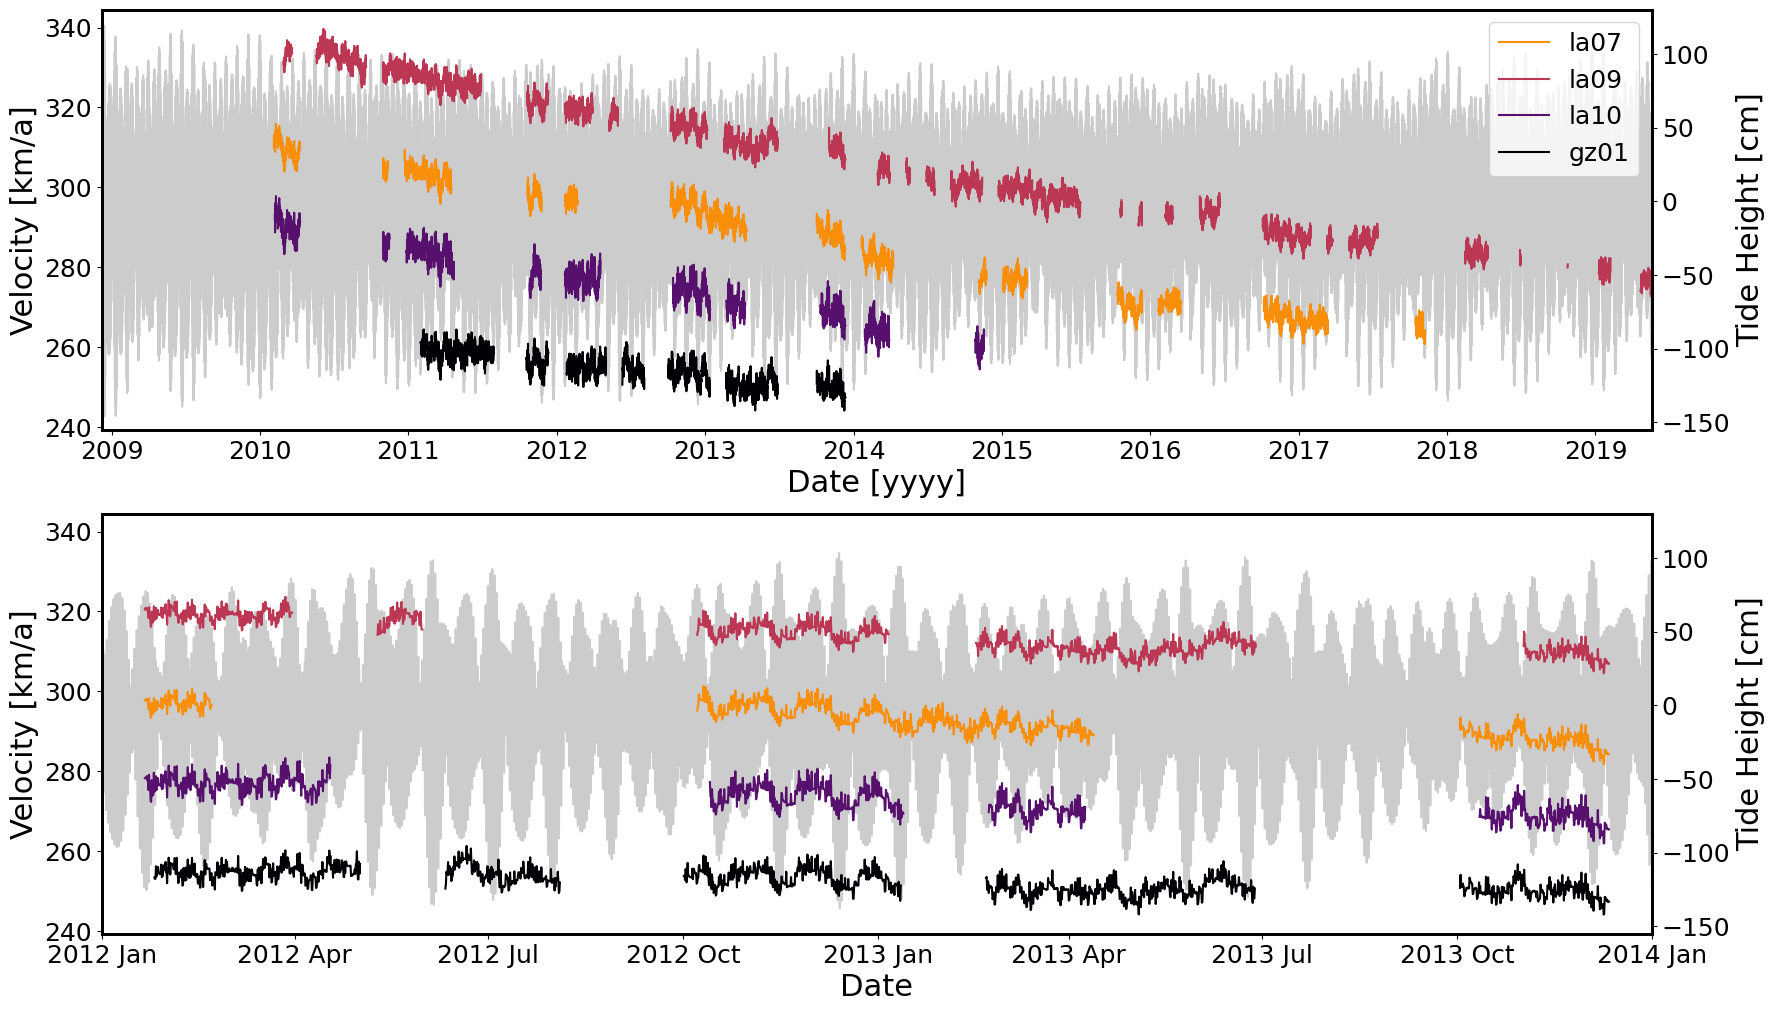

In [18]:
fig, (ax1, ax3) = plt.subplots(2, figsize=(20, 12))

colors = ["#f5db4c", "#f78410", "#cb4149", "#85216b", "#390963", "#000004"]
colors = ["#f98e09", "hi", "#bc3754", "#57106e", "#000004", "hi"]

(ax1.plot(dates_timeseries, ev_data["tidesgz05"], zorder=1, color="gray", alpha=0.4),)
for start, interval in zip(no_data["starts"][:], no_data["interval"][:]):
    start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
    rect = plt.Rectangle(
        (start, -200), interval, 1000, facecolor="black", alpha=0.2, zorder=3
    )
    # ax1.add_patch(rect)
ax1.set_ylim(-155, 130)

ax2 = ax1.twinx()
for avg_middle, average, color, sta in zip(avg_middles, avg, colors, stas):
    if sta not in ["la08", "gz14"]:
        ax2.plot(avg_middle, average, color=color, label=sta)
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax2.yaxis.set_label_position("left")
ax2.yaxis.tick_left()
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

ax1.set_xlabel("Date [yyyy]", size=22)
ax1.set_ylabel("Tide Height [cm]", size=22)
ax2.set_ylabel("Velocity [km/a]", size=22)

ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax2.legend(fontsize=18)
ax1.set_xlim(datetime.datetime(2008, 12, 8), datetime.datetime(2019, 5, 20))


(ax3.plot(dates_timeseries, ev_data["tidesgz05"], zorder=1, color="gray", alpha=0.4),)
for start, interval in zip(no_data["starts"][:], no_data["interval"][:]):
    start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
    rect = plt.Rectangle(
        (start, -200), interval, 1000, facecolor="black", alpha=0.2, zorder=3
    )
    # ax1.add_patch(rect)
ax3.set_ylim(-155, 130)
ax4 = ax3.twinx()

for avg_middle, average, color, sta in zip(avg_middles, avg, colors, stas):
    if sta not in ["la08", "gz14"]:
        ax4.plot(avg_middle, average, color=color)

# for i, (st,ed) in enumerate(zip(st_indices[0],ed_indices[0])):
#        ax3.plot(data[0].data['time'][st:ed], data[0].data['x'][st:ed],color = 'black',linewidth=0.1)

ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax4.yaxis.set_label_position("left")
ax4.yaxis.tick_left()
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%Y %b"))

ax3.set_xlabel("Date", size=22)
ax3.set_ylabel("Tide Height [cm]", size=22)
ax4.set_ylabel("Velocity [km/a]", size=22)

ax3.xaxis.set_tick_params(labelsize=18)
ax3.yaxis.set_tick_params(labelsize=18)
ax4.yaxis.set_tick_params(labelsize=18)
ax3.set_xlim(datetime.datetime(2012, 1, 1), datetime.datetime(2014, 1, 1))

In [19]:
# Spectrogram
i = 0
avg_vel_detrendeds = []
dates_as_secs = []
for i in [0, 2, 3, 4]:
    dates_as_sec = [a.timestamp() for a in avg_middles[i]]
    avg_vel_masked = np.ma.masked_array(avg[i], mask=np.invert(~np.isnan(avg[i])))
    dates_as_sec_masked = np.ma.masked_array(
        dates_as_sec, mask=np.invert(~np.isnan(avg[i]))
    )
    avg_vel_masked = np.ma.compressed(avg_vel_masked)
    dates_as_sec_masked = np.ma.compressed(dates_as_sec_masked)
    avg_vel_detrended = scipy.signal.detrend(avg_vel_masked)
    avg_vel_detrendeds.append(avg_vel_detrended)
    dates_as_secs.append(dates_as_sec_masked)

1491.3157894736842 Days, Power = 0.26558221782782954
809.5714285714284 Days, Power = 0.021969800461111706
691.0975609756097 Days, Power = 0.035999752732612814
464.50819672131144 Days, Power = 0.06537107784476863
358.67088607594934 Days, Power = 0.047931684884185345
292.11340206185565 Days, Power = 0.18155147460422913
213.04511278195488 Days, Power = 0.03904153034989613
200.95744680851064 Days, Power = 0.057451512935605235
182.80645161290323 Days, Power = 0.03865300848630314
167.6627218934911 Days, Power = 0.05207418135964175
133.0281690140845 Days, Power = 0.07921830603523201
111.99604743083003 Days, Power = 0.06689461132847682
97.37113402061854 Days, Power = 0.028176212714966436
92.29641693811074 Days, Power = 0.027369065626721048
86.12462006079025 Days, Power = 0.04817384144593613
73.59740259740259 Days, Power = 0.032107771951456594
35.64150943396226 Days, Power = 0.02852571787973879
34.93834771886559 Days, Power = 0.022338547958885
31.801346801346796 Days, Power = 0.0723125074012515

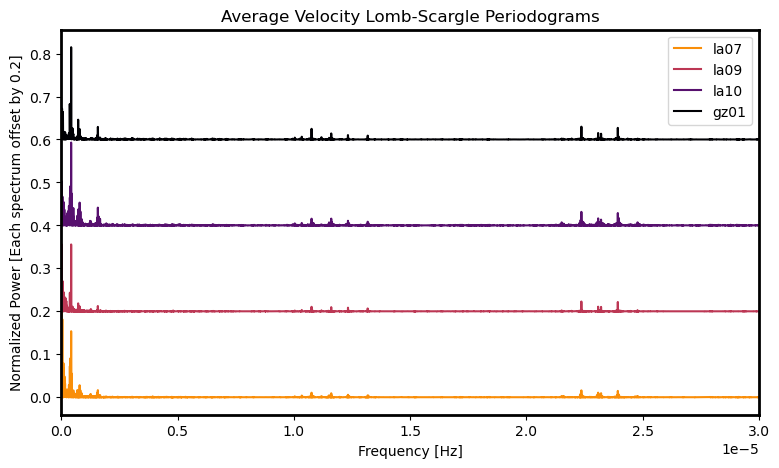

In [22]:
# Spectrogram of rolling avg slips using lomb scargle
fig, ax = plt.subplots(figsize=(9, 5))
offset = 0
colors = ["#f98e09", "#bc3754", "#57106e", "#000004"]
stas = ["la07", "la09", "la10", "gz01"]
for avg_vel_detrended, dates_as_sec_masked, color, sta in zip(
    avg_vel_detrendeds, dates_as_secs, colors, stas
):
    frequency, power = LombScargle(dates_as_sec_masked, avg_vel_detrended).autopower()
    pks = scipy.signal.find_peaks(power, height=0.02)[0]
    # ax.plot(frequency[pks], power[pks], 'ro')
    ax.plot(frequency, power + offset, color=color, label=sta)
    offset += 0.2
    ax.set_title("Average Velocity Lomb-Scargle Periodograms")
    ax.set_xlabel("Frequency [Hz]")
    ax.set_ylabel("Normalized Power [Each spectrum offset by 0.2]")
    ax.set_xlim(0, 3e-5)
    # ax.set_ylim(0,2)
    ax.legend()

    SEC_TO_DAY = 3600 * 24
    SEC_TO_HR = 3600
    for pk, pwr in zip(frequency[pks], power[pks]):
        if pk < 0.25e-5:
            print(f"{1/pk/SEC_TO_DAY} Days, Power = {pwr}")
        else:
            print(f"{1/pk/SEC_TO_HR} Hours, Power = {pwr}")
    print("")